In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import KDTree
from scipy.interpolate import griddata
from sklearn.preprocessing import MinMaxScaler

In [2]:
from model.GraphComplete import GraphComplete
from model.NodeClass import NodeCrossRef
from model.LinkClass import LinkCrossRef
from model.Plotteable import Vertex, Edge

In [3]:
graph = GraphComplete.of("../network_plotter/Passion_Xtreme_III.mat", "../network_plotter/NameTypes.xlsx")

Discarded nodes: 39
Discarded links: 0
Vertexs: 154
Edges: 174
LinksObj: 174
NodesObj: 154

*-*-* Printing information about the imported network *-*-*

Num nodes: 154
Num links: 174
Num HL4: 20
Num HL5: 134
Average distance: 2.58
Max distance (km): 22.00
Min distance (km): 0.18
Average degree: 2.27
Min degree: 1
Max degree: 10
Average degree HL4: 1.95
Average degree HL5: 2.32
Total bidirectional link length (km): 448.84


In [4]:
graph.compute_traffic_profiles()

In [5]:
graph.nodesObj

[NodeCrossRef(name='02-00001_AN_1', pos=(-0.3427555207831287, 0.7832944463895565), node_degree=2, type='HL5', traffic_profile='low', estimated_traffic_injection=250, assoc_links=['02-00001_AN_1 <-> 02-03095_AN_1', '02-00001_AN_1 <-> 02-03021_AN_1'], assoc_nodes=['02-03095_AN_1', '02-03021_AN_1']),
 NodeCrossRef(name='02-00002_AN_1', pos=(-0.010892967629246094, -0.11819118063981306), node_degree=3, type='HL5', traffic_profile='high', estimated_traffic_injection=1000, assoc_links=['02-00002_AN_1 <-> 02-00051_AN_1', '02-00002_AN_1 <-> 02-02225_AN_1', '02-00002_AN_1 <-> 02-02416_AN_1'], assoc_nodes=['02-00051_AN_1', '02-02225_AN_1', '02-02416_AN_1']),
 NodeCrossRef(name='02-00006_AN_1', pos=(0.4500867656274771, -0.30179398425575676), node_degree=2, type='HL5', traffic_profile='medium', estimated_traffic_injection=500, assoc_links=['02-00006_AN_1 <-> 02-02210_AN_1', '02-00006_AN_1 <-> 02-03003_AN_1'], assoc_nodes=['02-02210_AN_1', '02-03003_AN_1']),
 NodeCrossRef(name='02-00007_AN_1', pos=(

In [11]:
count_low_profiles = sum([1 if node.traffic_profile == "low" else 0 for node in graph.nodesObj])
count_medium_profiles = sum([1 if node.traffic_profile == "medium" else 0 for node in graph.nodesObj])
count_high_profiles = sum([1 if node.traffic_profile == "high" else 0 for node in graph.nodesObj])

print(f"Count of low profiles: {count_low_profiles}")
print(f"Count of medium profiles: {count_medium_profiles}")
print(f"Count of high profiles: {count_high_profiles}")

Count of low profiles: 154
Count of medium profiles: 154
Count of high profiles: 154


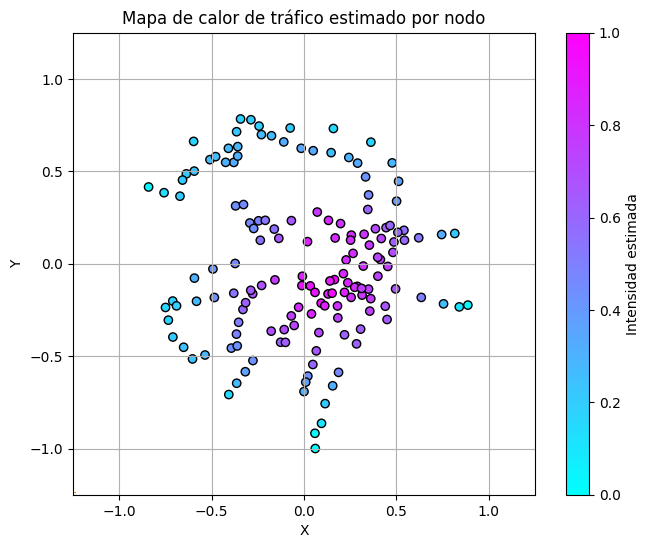

In [ ]:
x, y = Vertex.obtain_x_y_vectors(graph.vertexs)
degree = Vertex.obtain_degree_vector(graph.vertexs)

df = pd.DataFrame({'x': x, 'y': y, 'degree': degree})

# Calcular densidad local: cuántos vecinos en cierto radio
tree = KDTree(df[['x', 'y']])
radio = 0.5  # puedes ajustar esto
densidad = []

for i in range(len(df)):
    vecinos = tree.query_ball_point([df.loc[i, 'x'], df.loc[i, 'y']], r=radio)
    densidad.append(len(vecinos) - 1)  # excluye el propio nodo

df['densidad'] = densidad

# Estimar intensidad de tráfico
alpha = 1.0
beta = 1.0
df['intensidad'] = alpha * df['densidad'] + beta * df['degree']


# Normalizar para visualización
scaler = MinMaxScaler()
df['intensidad_norm'] = scaler.fit_transform(df[['intensidad']])



# Clasificar cada nodo según su intensidad
# [0, 0.4) -> 0
# [0.4, 0.7) -> 1
# [0.7, 1.0] -> 2

# TODO: Implementar clasificación y asignar en los objetos de nodos





# Crear grid para mapa de calor
grid_x, grid_y = np.mgrid[0:100:200j, 0:100:200j]
grid_z = griddata(df[['x', 'y']], df['intensidad_norm'], (grid_x, grid_y), method='cubic')

# Visualizar mapa de calor + nodos
plt.figure(figsize=(8, 6))
plt.imshow(grid_z.T, extent=(-1.25, 1.25, -1.25, 1.25), origin='lower', cmap='hot', alpha=0.7)
plt.scatter(df['x'], df['y'], c=df['intensidad_norm'], cmap='cool', edgecolor='k')
plt.colorbar(label='Intensidad estimada')
plt.title('Mapa de calor de tráfico estimado por nodo')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.show()
